In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

# Independent Telegraphs with regulation

We consider a stochastic reaction network where 2 telegraph models act independently, each with a gene that switches between on and off and produces transcripts, except that the 2 transcripts regulate each other:

$ G_{1, off} \underset{k_{1, off}}{\stackrel{k_{1, on}}{\rightleftharpoons}} G_{1, on}  \quad\quad G_{2, off} \underset{k_{2, off}}{\stackrel{k_{2, on}}{\rightleftharpoons}} G_{2, on}$

$ G_{1, on} \stackrel{k_{1, tx}}\longrightarrow G_{1, on} + X_{1} \quad\quad G_{2, on} \stackrel{k_{2, tx}}\longrightarrow G_{2, on} + X_{2} $

$ X_{1} \stackrel{k_{1, deg}}\longrightarrow \varnothing \quad\quad X_{2} \stackrel{k_{2, deg}}\longrightarrow \varnothing $

$ X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $

Again we observe only the number of molcules of the transcripts $X_{1}$ and $X_{2}$ but not the state of the genes $G_{1}$ and $G_{2}$.

The state of the system can be written as $(x_{1}, x_{2}, g_{1}, g_{2}) \in \mathbb{N}^{2} \times \{0, 1\}^{2}$ where $0$ denotes the off state and $1$ the on state of each gene.

## Simulation

Without an explicit stationary distribution we instead use gillespie / SSA to simulate sample paths of the reaction network. After a sufficient time (burn in) we can take the state of the system as a sample from the stationary distribution.

In [2]:
rng = np.random.default_rng(12)

In [3]:
def simulation(params, n, tmax, ts, plot=False, initial_state=(0, 0, 1, 1)):
    '''
    Simulate a sample path of the telegraph-regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2, g1, g2 = path[-1][0], path[-1][1], path[-1][2], path[-1][3]

        # transition rates
        q_on_1 = (1 - g1) * params['k_on_1']
        q_on_2 = (1 - g2) * params['k_on_2']
        q_off_1 = g1 * params['k_off_1']
        q_off_2 = g2 * params['k_off_2']
        q_tx_1 = g1 * params['k_tx_1']
        q_tx_2 = g2 * params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_on_1 + q_on_2 + q_off_1 + q_off_2 + q_tx_1 + q_tx_2 + \
            q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        prob = [
            q_on_1 / q_hold,
            q_on_2 / q_hold,
            q_off_1 / q_hold,
            q_off_2 / q_hold,
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1, x2, g1 + 1, g2))
            case 2:
                path.append((x1, x2, g1, g2 + 1))
            case 3:
                path.append((x1, x2, g1 - 1, g2))
            case 4:
                path.append((x1, x2, g1, g2 - 1))
            case 5:
                path.append((x1 + 1, x2, g1, g2))
            case 6:
                path.append((x1, x2 + 1, g1, g2))
            case 7:
                path.append((x1 - 1, x2, g1, g2))
            case 8:
                path.append((x1, x2 - 1, g1, g2))
            case 9:
                path.append((x1 - 1, x2 - 1, g1, g2))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

### Example

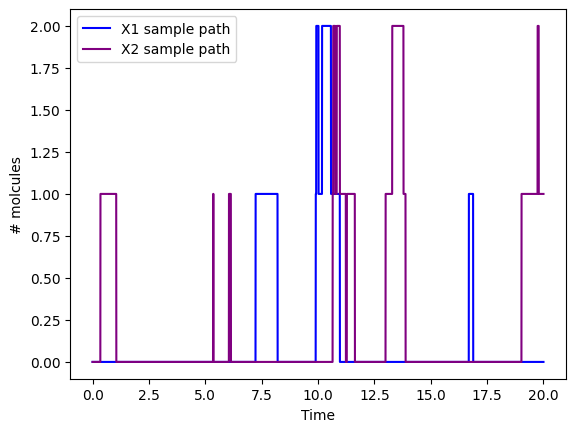

In [4]:
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
samples = simulation(params, 2, 10, 10, plot=True)

## Bootstrap

Given samples from the staitonary distribution of the reaction network we compute confidence intervals on the probabilities of the distribution using the bootstrap. By resampling and computing the empirical distribution on each sample we can produce 95% confidence intervals.

NOTE: previous efficient bootstrap no longer works, as cannot use bincount on pairs of integers

In [5]:
def bootstrap(params, n, B, tmax=100, ts=10, plot=False, printing=False, initial_state=(0, 0, 1, 1)):
    '''
    Compute bootstrap confidence intervals on the stationary distribution of system
    Simulate sample path and compute empirical distribution over each bootstrap sample

    params: dict of reaction rate constants
    n: number of samples from the stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    # n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # separate x1 and x2 values (always considered paired, but for computational reasons)
    x1_samples = [sample[0] for sample in samples]
    x2_samples = [sample[1] for sample in samples]

    # maximum values found (+ 1)
    M = np.max(x1_samples) + 1
    N = np.max(x2_samples) + 1

    # array to count occurances per state per bootstrap sample
    counts = np.zeros((B, M, N))

    # B bootstrap samples of size n in B x n array
    boot = rng.choice(samples, size=(B, n))

    # loop over each sample (row) and add to counts
    for b in range(B):
        for i in range(n):
            x1, x2 = boot[b, i]
            counts[b, x1, x2] += 1

    # normalize counts to probabilities
    counts /= n

    # take 2.5%, 97.5% percentiles for each p(x1, x2)
    # gives 2 x M x N array of lower and upper bounds (axis 0) for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)

    # plotting
    if plot:
        fig, axs = plt.subplots(M, N, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M):
            for x2 in range(N):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("Confidence Intervals")
        plt.show()

    return bounds

### Example

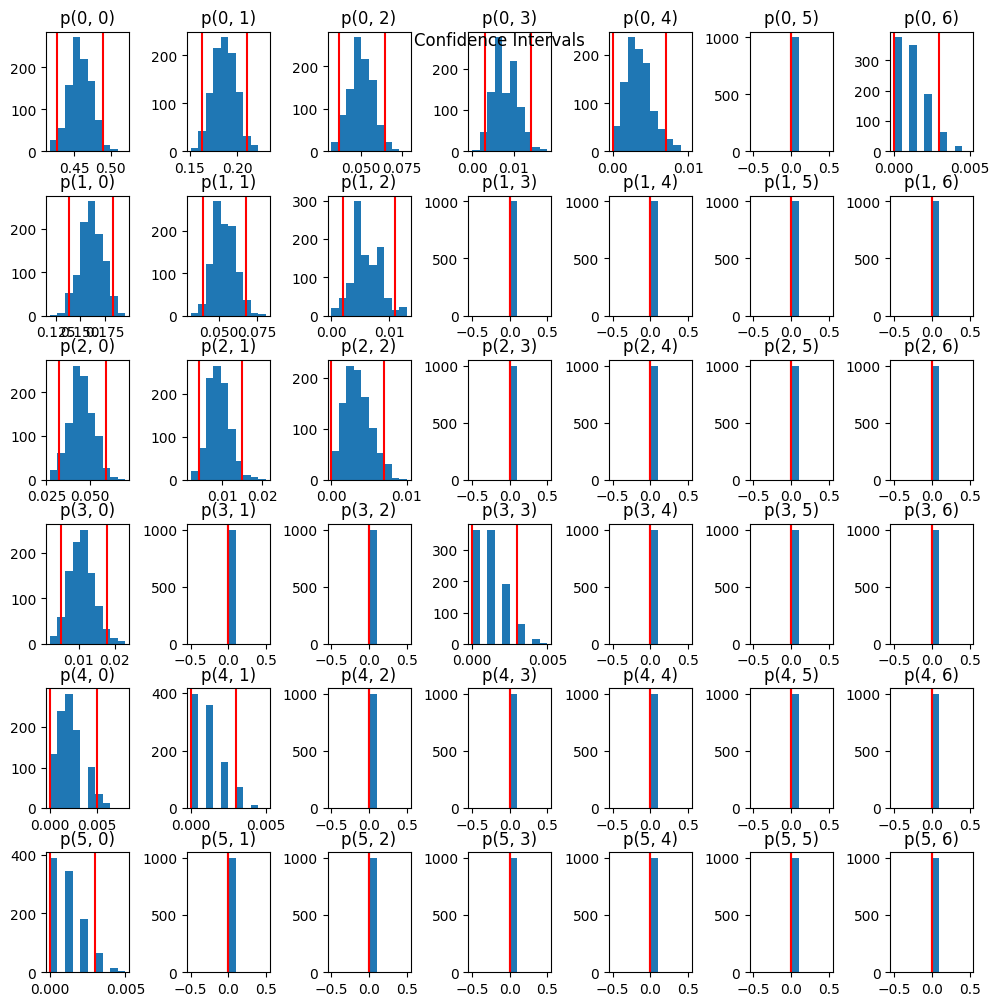

In [6]:
bounds = bootstrap(params, 1000, 1000, plot=True)

## Optimization

In [7]:
def optimization(params, bounds, N=None, M=None, K=10, silent=True):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: variable or fixed reaction rate constants
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('telegraph-regulation')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # create variables

    # stationary distribution
    p = md.addMVar(shape=(M, N, 2, 2), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    #for param, value in params.items():
    #    if value == "v":
    #        exec(f"{param} = md.addVar(vtype=GRB.CONTINUOUS, name='{param}', lb=0, ub={K})")
    #    else:
    #        exec(f"{param} = {value}")

    # on
    if params['k_on_1'] == "v":
        k_on_1 = md.addVar(vtype=GRB.CONTINUOUS, name="k_on_1", lb=0, ub=K)
    else:
        k_on_1 = params['k_on_1']
    if params['k_on_2'] == "v":
        k_on_2 = md.addVar(vtype=GRB.CONTINUOUS, name="k_on_2", lb=0, ub=K)
    else:
        k_on_2 = params['k_on_2']
    # off
    if params['k_off_1'] == "v":
        k_off_1 = md.addVar(vtype=GRB.CONTINUOUS, name="k_off_1", lb=0, ub=K)
    else:
        k_off_1 = params['k_off_1']
    if params['k_off_2'] == "v":
        k_off_2 = md.addVar(vtype=GRB.CONTINUOUS, name="k_off_2", lb=0, ub=K)
    else:
        k_off_2 = params['k_off_2']
    # tx
    if params['k_tx_1'] == "v":
        k_tx_1 = md.addVar(vtype=GRB.CONTINUOUS, name="k_tx_1", lb=0, ub=K)
    else:
        k_tx_1 = params['k_tx_1']
    if params['k_tx_2'] == "v":
        k_tx_2 = md.addVar(vtype=GRB.CONTINUOUS, name="k_tx_2", lb=0, ub=K)
    else:
        k_tx_2 = params['k_tx_2']
    # deg
    if params['k_deg_1'] == "v":
        k_deg_1 = md.addVar(vtype=GRB.CONTINUOUS, name="k_deg_1", lb=0, ub=K)
    else:
        k_deg_1 = params['k_deg_1']
    if params['k_deg_2'] == "v":
        k_deg_2 = md.addVar(vtype=GRB.CONTINUOUS, name="k_deg_2", lb=0, ub=K)
    else:
        k_deg_2 = params['k_deg_2']
    # reg
    if params['k_reg'] == "v":
        k_reg = md.addVar(vtype=GRB.CONTINUOUS, name="k_reg", lb=0, ub=K)
    else:
        k_reg = params['k_reg']

    # constraints
    # (marginal) stationary distribution bounds
    for m in range(M):
        for n in range(N):
            md.addConstr(bounds[0, m, n] <= p[m, n, 0, 0] + p[m, n, 1, 0] + p[m, n, 0, 1] + p[m, n, 1, 1], name=f"Marginal lb {m}, {n}")
            md.addConstr(bounds[1, m, n] >= p[m, n, 0, 0] + p[m, n, 1, 0] + p[m, n, 0, 1] + p[m, n, 1, 1], name=f"Marginal ub {m}, {n}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # add all involving relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    if x1 == 0:
                        x1_zero = 0
                    else:
                        x1_zero = 1
                    if x2 == 0:
                        x2_zero = 0
                    else:
                        x2_zero = 1

                    md.addConstr( 
                        k_on_1 * g1 * p[x1, x2, 0, g2] + \
                        k_on_2 * g2 * p[x1, x2, g1, 0] + \
                        k_off_1 * (1 - g1) * p[x1, x2, 1, g2] + \
                        k_off_2 * (1 - g2) * p[x1, x2, g1, 1] + \
                        # need to remove this when x1 or x2 = 0, since not in equation (index = -1 crrently taking end of array)
                        # so multiply by toggle
                        k_tx_1 * g1 * x1_zero * p[x1 - 1, x2, g1, g2] + \
                        k_tx_2 * g2 * x2_zero * p[x1, x2 - 1, g1, g2] + \
                        k_deg_1 * (x1 + 1) * p[x1 + 1, x2, g1, g2] + \
                        k_deg_2 * (x2 + 1) * p[x1, x2 + 1, g1, g2] + \
                        k_reg * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1, g1, g2] - \
                        (k_on_1 * (1 - g1) + k_on_2 * (1 - g2) + k_off_1 * g1 + k_off_2 * g2 + \
                         k_tx_1 * g1 + k_tx_2 * g2 + k_deg_1 * x1 + k_deg_2 * x2 + k_reg * x1 * x2) * p[x1, x2, g1, g2] == 0,
                        name=f"Equation {x1}, {x2}, {g1}, {g2}"
                    )

    # optimize
    md.setObjective(k_tx_1, GRB.MINIMIZE)
    md.optimize()
    lb = md.ObjVal
    md.setObjective(k_tx_1, GRB.MAXIMIZE)
    md.optimize()
    ub = md.ObjVal
    print(lb, ub)
        

### Example

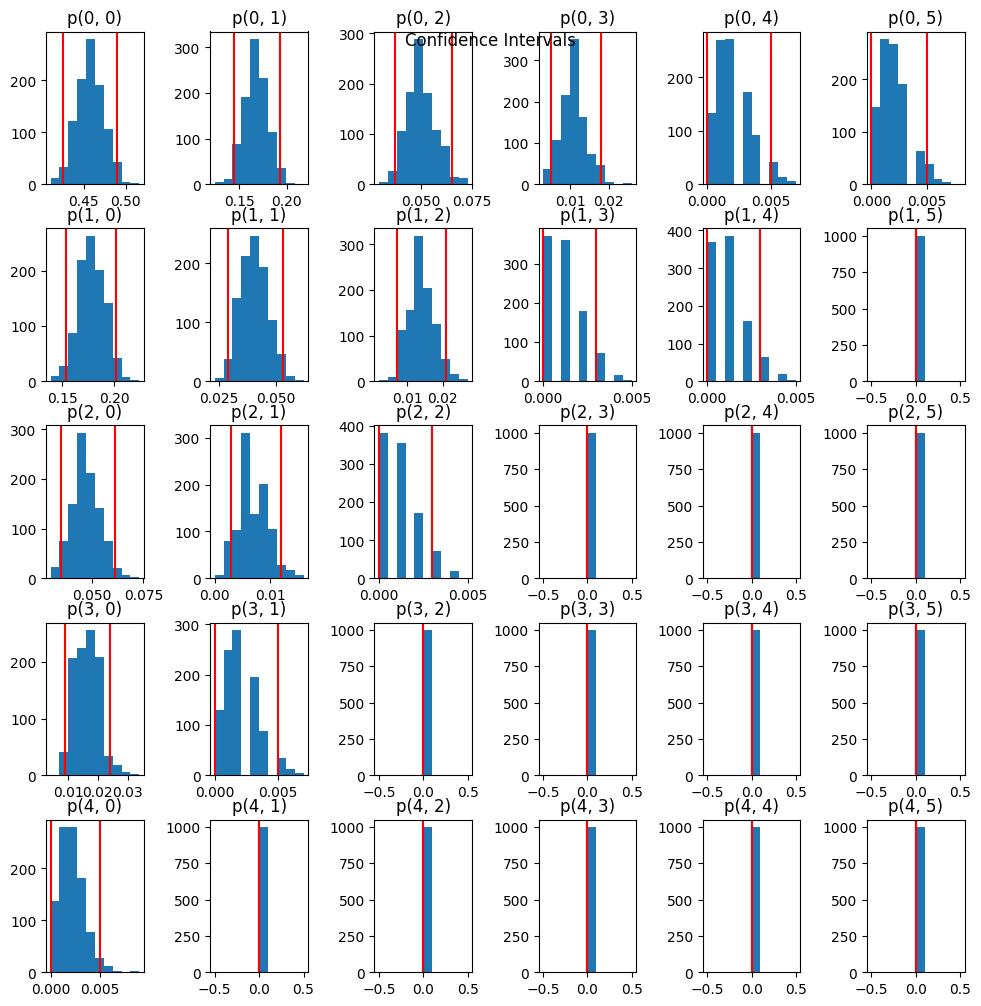

In [9]:
# set parameter values for simulation
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
# choose variable / fixed parameters for optimization
params_optim = {
    'k_on_1': "v",
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': "v",
    'k_reg': 1
}
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds = bootstrap(params, 1000, 1000, plot=True)

In [10]:
bounds.shape

(2, 5, 6)

In [19]:
optimization(params_optim, bounds, M=4, N=4, silent=False)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 33 rows, 72 columns and 192 nonzeros
Model fingerprint: 0x5ed66885
Model has 36 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 3e+00]
  QLMatrix range   [1e+00, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [3e-03, 1e+00]
Presolve removed 16 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 9 rows and 12 columns
Presolve time: 0.00s
Presolved: 748 rows, 232 columns, 1876 nonzeros
Presolved model has 172 bilinear constraint(s)
Variable types: 232 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.05 